In [1]:
#Connecting to the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Current path
%cd /content/drive/Shareddrives/PRUEBAS_BANCOLOMBIA_SMITH/Prueba practica
!pwd

/content/drive/Shareddrives/PRUEBAS_BANCOLOMBIA_SMITH/Prueba practica
/content/drive/Shareddrives/PRUEBAS_BANCOLOMBIA_SMITH/Prueba practica


In [3]:
!pip install textract-trp
!pip install PyMuPDF Pillow -q
!pip install opencv-python

In [4]:
import json
import trp
#import cv2
import re

import fitz
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
def load_json (files):
  """
  Carga los datos de un archivo JSON.

  Args:
    Files: Archivo  JSON.

  Returns:
   Objeto tipo trp.
  """
  with open(files, 'r') as f:
      data = json.load(f)

  doc = trp.Document(data)

  return doc

In [6]:
def clean_text_words(text):
    # Utilizar una expresión regular para eliminar puntos y comas
    clean_text = re.sub(r'[.,:]', '', text.strip())

    return clean_text

In [7]:
def format_date(text_date):

  date = text_date.split('de')
  month = {'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4, 'mayo': 5, 'junio': 6,
        'julio': 7, 'agosto': 8, 'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12}
  month_num = month.get(date[1].strip().lower())
  # Formatear la fecha en el formato YYYY-MM-DD
  fecha_formateada = f"{date[-1][:5]}-{month_num:02d}-{int(date[0]):02d}"
  return fecha_formateada

In [8]:
def get_value(expresion, lines,flag_first = False):
  """
  Obtiene la información que se requiere a partir de la expresión regular.

  Args:
    expresion: Expresión regular.
    linea: Línea de texto.
    flag_first: Match de la expresión regular

  Returns:
    Información del campo en el documento.
  """
  for line in  lines:

    line_text = line.text
   # print(expresion)
    if line_text:
      match_re = list(map(lambda x : re.compile(x).search(line_text), expresion))
      coincidencia = list(set(match_re))[0]

      #coincidencia = expresion.search(line_text)
      if coincidencia is not None and (flag_first == False):
        value = coincidencia.group(1)
        if value is not  None:
          return (value , line)
      elif coincidencia is not None and (flag_first != False):
        value = coincidencia.group(0)
        if value is not  None:
          return (value, line)
  return (None,None)

In [9]:
def extract_fields(json_path):

  # Matricula
  registration_number = [
      r'Nro Matrícula+(.*)' , r'Nro Matricula+(.*)',
      r'Nro\s*Matricula\s*:\s*(\d+[-\d]*)', r'Nro\s*Matricula\s*:\s*(\d{3}-\d{7})',
      r'Nro\s*de?\s*Matrícula:\s*(\d+[-\s]?\d+)', r'Nro\s*Matrícula:\s*(\S+)$' ]

  # Print date YYYY-MM-DD format
  print_date = [r'Impreso el\s+(.*)']

  # The deparment
  departament = [
      r'DEPTO:\s+(?P<departamento>\w+)', r'DEPTO:\s+(?P<departamento>\w{1,})',
      r'DEPTO:\s+(?P<departamento>\S+)']

  # Municipality
  municipality = [r'MUNICIPIO:\s+(?P<municipio>\w+)']

  #Locality
  locality = [r'VEREDA+(.*)']

  #Status of the folio
  status_folio = [r"ACTIVO+(.*)|CERRADO+(.*)"]

  data_load = load_json(json_path)
  lines = data_load.pages[0].lines
  dict_out = {}

  rn, line_rn = get_value(registration_number,lines)
  dict_out['registration_number'] = clean_text_words(rn).strip()

  dc, line_dc = get_value(print_date,lines)
  date_clean = format_date(dc).strip()
  dict_out['print_date'] =clean_text_words(date_clean.strip())

  dep, dep_line = get_value(departament,lines)
  dict_out['departament'] = clean_text_words(dep)

  mun, line_mun = get_value(municipality,lines)
  dict_out['municipality'] = clean_text_words(mun)

  loc, line_loc = get_value(locality,lines)
  dict_out['locality'] = clean_text_words(loc)

  sf , line_sf = get_value(status_folio,lines,True)
  dict_out['status_folio'] = clean_text_words(sf)

  lines = [line_rn, line_dc ,dep_line, line_mun, line_loc, line_sf ]

  return (dict_out,lines)

## Acplicación de Computer Vision

 Usaremos computer vision para identificar donde se encuentran las cajas con el fin de validar que los datos encontrados si sean los valores deseados

In [10]:
def convertir_pdf_a_imagenes(ruta_pdf, ruta_salida):
    documento = fitz.open(ruta_pdf)

    for pagina in range(documento.page_count):
        pagina_pdf = documento.load_page(pagina)
        imagen = pagina_pdf.get_pixmap()

        imagen_pil = Image.frombytes("RGB", [imagen.width, imagen.height], imagen.samples)
        imagen_pil.save(f"{ruta_salida}_pagina_{pagina + 1}.png")  # Guardar cada página como imagen PNG

    documento.close()

In [12]:
def grap_boxes(path_png, lines):

  fig, ax = plt.subplots(figsize=(15, 15))
  ax.imshow(plt.imread(path_png))

  for line in lines:
    if line:
      left = line.geometry.boundingBox.left
      top = line.geometry.boundingBox.top
      height = line.geometry.boundingBox.height
      width = line.geometry.boundingBox.width

      rect = patches.Rectangle(
          (left*617, top*792), width*617 , height*792,
          linewidth=1, edgecolor='b', facecolor='none')
      ax.add_patch(rect)

  return plt.show()


In [11]:
# Usuario debe cambiar path
json_001_pag1 =  './files/001-1007202-220301269555588250_pag1.json'
json_041_pag1 = './files/040-464031-220204640254303951_pag1.json'


pdf1 =  './files/001-1007202-220301269555588250.pdf'
pdf2 = './files/040-464031-220204640254303951.pdf'

png1 = r'./files/pdf1_pagina_1.png'
png2 = r'./files/pdf2_pagina_1.png'

# convertir_pdf_a_imagenes(pdf1,  r'./files/pdf1')
# convertir_pdf_a_imagenes(pdf2,  r'./files/pdf2')

----------------------------------------------------------------------------------------------------
Resultado para el documento 1 
----------------------------------------------------------------------------------------------------
{'registration_number': '001-1007202', 'print_date': '2022-03-01', 'departament': 'ANTIOQUIA', 'municipality': 'MEDELLIN', 'locality': ' MEDELLIN', 'status_folio': 'ACTIVO'}
----------------------------------------------------------------------------------------------------


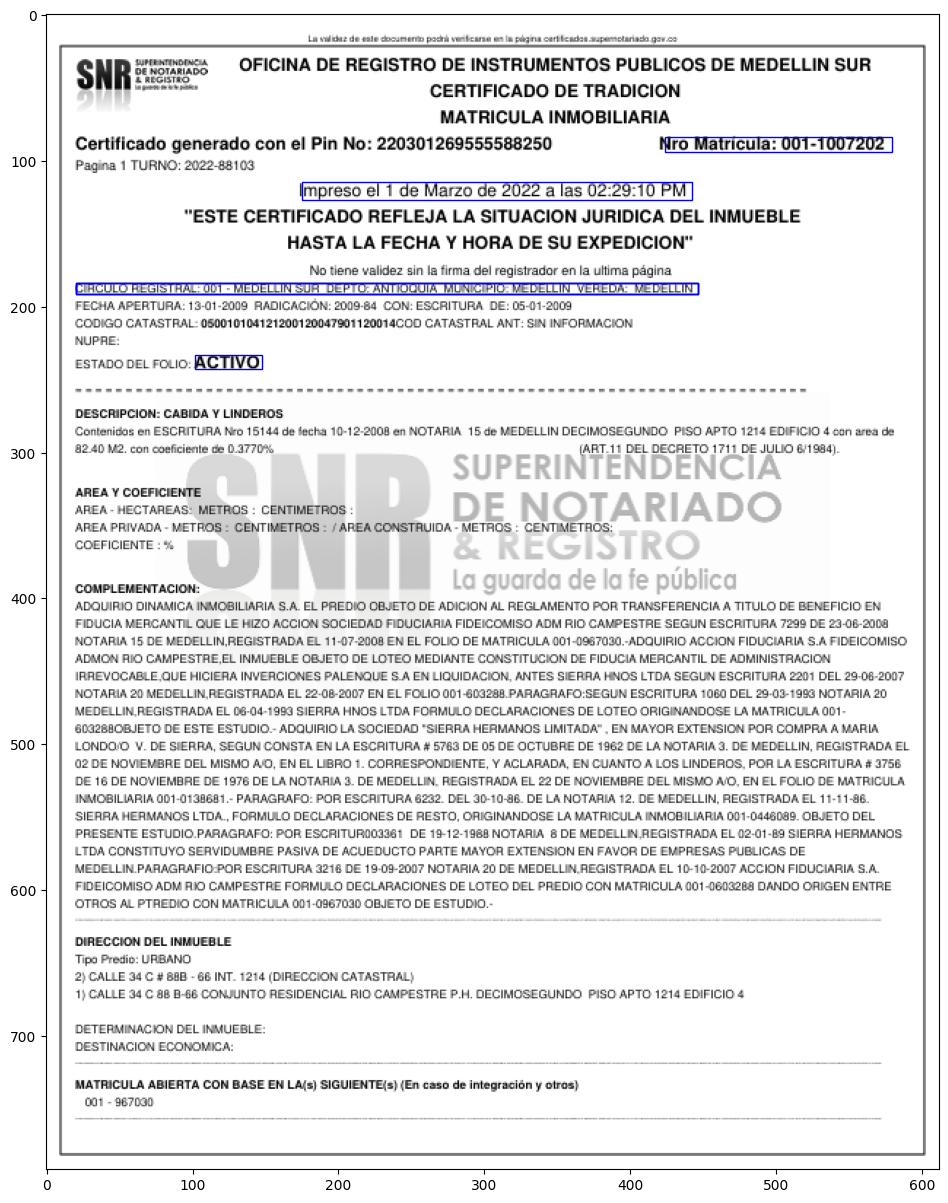

In [13]:
result1, lines1  = extract_fields(json_001_pag1)
print('-'*100)
print("Resultado para el documento 1 ")
print('-'*100)
print(result1)
print('-'*100)
#grap_boxes(png1, lines1)

----------------------------------------------------------------------------------------------------
Resultado para el documento 2 
----------------------------------------------------------------------------------------------------
{'registration_number': '040-464031', 'print_date': '2022-02-04', 'departament': 'ATLANTICO', 'municipality': 'BARRANQUILLA', 'locality': ' BARRANQUILLA', 'status_folio': 'ACTIVO'}
----------------------------------------------------------------------------------------------------


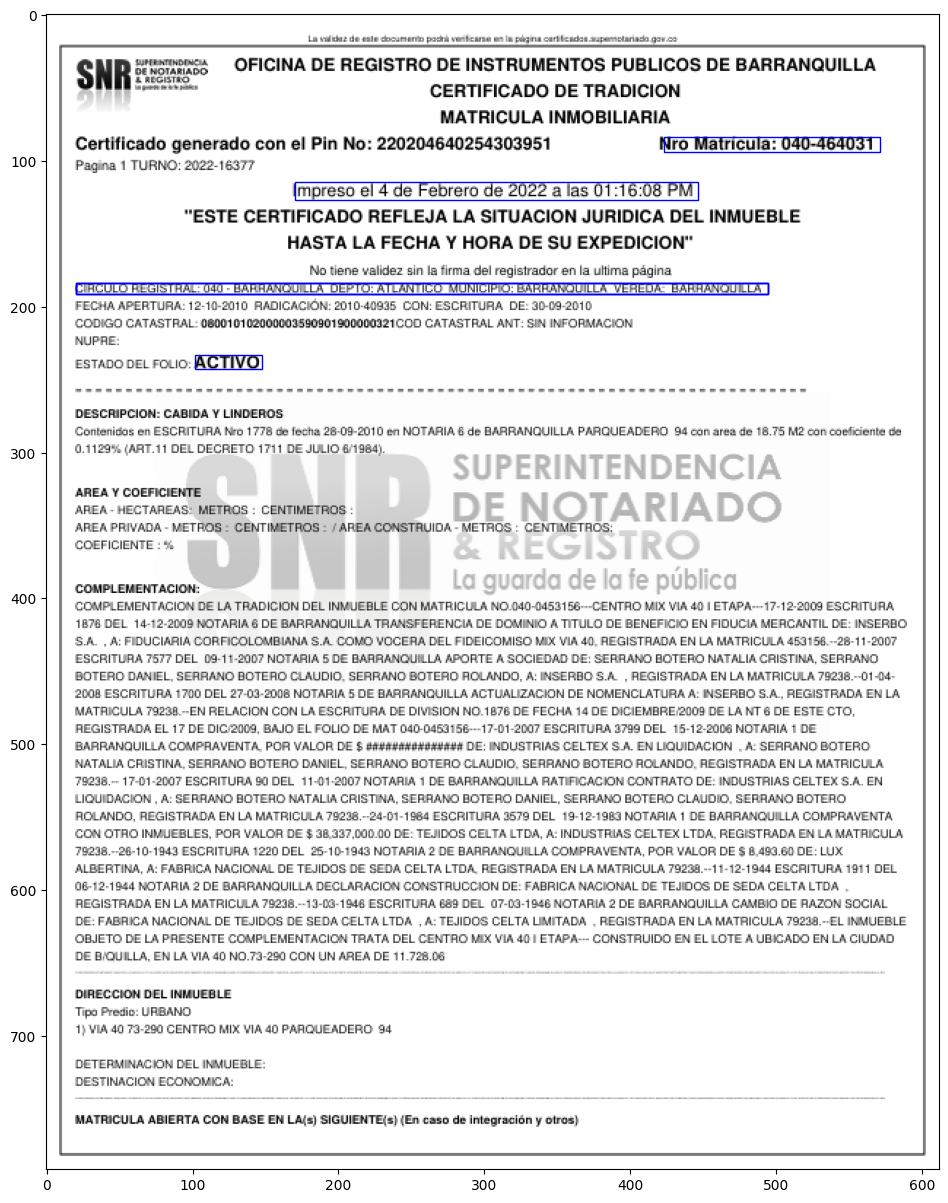

In [14]:
result2, lines2  = extract_fields(json_041_pag1)
print('-'*100)
print("Resultado para el documento 2 ")
print('-'*100)
print(result2)
print('-'*100)
#grap_boxes(png2, lines2)